### TODO:
- Chart with:
    - Identify pivot points, and build systems that identify resistance and support lines 
    - Identify lines where the price closes and open, plot a line with low alpha and frequently lines will overlay to create a thicker line.

- Make a method to be updating the orderbook every 5 minutes, and do live udpates: https://pythonprogramming.net/python-matplotlib-live-updating-graphs/
    - Update rounding method to not always round down.
    - Add in bollinger band lines and line for current price, and generates graph around current price with $500 bounds
    - Post data to twitter for moolah
- Create a method for viewing the charts by their order id's to see if its the same person generating orders. 
- Figure out how to calculate the number of BTC in circulation at Coinbase, and then use that as a basis to determine how much a price might drop by the change in value of the marketcap (https://www.quora.com/What-is-the-formula-to-calculate-a-price-of-a-cryptocurrency)
- Work on the equity-AEI project
- Get a model to use lagging indicators, and then use all of those values to forecast the price. Need to build the dataset over time. Collected every ten minutes? Need to look at the rate that I can request the full order book.
- I'd want to try and forecast the price how far in the future? Maybe I need a forecasting model, or a timeseries model.

## Readings so far on using ML to estimate price:
- How to do time series analyses in python: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- Should ML be used to forecast prices? : https://machinelearningmastery.com/findings-comparing-classical-and-machine-learning-methods-for-time-series-forecasting/ 
- How to not screw up using ML for forecasting: https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

### TODO:
- Create a twitter connection, so that everytime I run this order book,  it sends out a tweet. Or maybe make it iterate through a list of currencies. 

In [72]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt

In [73]:
from datetime import datetime

In [74]:
from matplotlib import animation, rc

In [75]:
from IPython.display import HTML

In [76]:
base_url = 'https://api.pro.coinbase.com'

In [77]:
products = '/products'

In [78]:
ticker = '/ticker'

In [79]:
book = '/book?level='

In [80]:
#Only shows best bid and ask
level_1 = '1'
#Only shows top 50 bids and asks
level_2 = '2'
#Shows all bids and asks
level_3 = '3'

In [81]:
curr1 = 'BTC'
curr2 = 'USD'
pair = '/' + curr1 + '-' + curr2

In [82]:
def round_num(num, round_to_val):
    while num % round_to_val != 0:
        num -= 1
    return num

In [83]:
round_num(111, 5)

110

In [84]:
def gen_ob(pair, level):
    data = requests.get(base_url + products + pair + book + level)
    data = json.loads(data.content.decode('utf-8').replace("'", '"'))
    bids = pd.DataFrame(data['bids'], columns=['price', 'amount', 'id'])
    asks = pd.DataFrame(data['asks'], columns=['price', 'amount', 'id'])
    bids['bid'] = 1
    asks['ask'] = 1
    ob = pd.concat([bids, asks])
    ob = ob.fillna(0)
    ob = ob.sort_values(by='price', ascending=False)
    ob['price'] = ob['price'].apply(lambda price: float(price))
    ob['amount'] = ob['amount'].apply(lambda amnt: float(amnt))
    ob['price'] = np.round(ob['price'], 0)
    ob['price'] = ob['price'].apply(lambda price: round_num(price, 1))
    ob_price = ob.groupby('price')
    result ={
        'price': [],
        'amount': [],
        'bid': [],
        'ask': []
    }
    for price in ob_price:
        result['price'].append(price[0])
        result['amount'].append(np.sum(price[1]['amount']))
        result['bid'].append(price[1]['bid'].tolist()[0])
        result['ask'].append(price[1]['ask'].tolist()[0])
    ob = pd.DataFrame(result)
    ob = ob.sort_values(by='price', ascending=False)
    ob['amount'] = ob['amount'].apply(lambda amnt: float(amnt))
    ob['amount'] = np.round(ob['amount'], 5)
    ob['price'] = ob['price'].apply(lambda price: int(price))
    ob['value'] = ob['price'] * ob['amount']
    curr1 = pair.split('-')[0].strip('/')
    curr2 = pair.split('-')[1]
    ob.to_excel(curr1+'_'+curr2+'_ob.xlsx')
    return ob

In [85]:
og_ob = gen_ob(pair, level_3)

In [86]:
def ob_range(ob, upper, lower, metric, amount=None, value=None):
    ob = ob[ob.price < upper]
    ob = ob[ob.price > lower]
    ob = ob.sort_values(by='price')
    colors = []
    for index in range(len(ob.price.tolist())):
        if ob['bid'].tolist()[index] == 1:
            colors.append('green')
        if ob['ask'].tolist()[index] == 1:
            colors.append('red')
    if not(amount is None):
        ob = ob[ob.amount > amount]
    if not(value is None):
        ob = ob[ob.value > value]
    ax1.clear()
    plt.grid(True)
    x = ob['price'].apply(lambda price: str(price)).tolist()
    y = ob[metric].tolist()
    ax1.barh(x,y,color=colors)
    plt.ylim([0, len(y)])
    title = 'Bids and Asks for '+ curr1+'-'+curr2 + ' on '+ str(datetime.today().strftime('%m-%d-%Y'))
    plt.title(title, loc='center',fontdict={'fontsize':20})
    plt.xticks(rotation=45,fontsize='medium')
    xlabel = 'Price of ' + curr1
    plt.xlabel(xlabel, fontsize='x-large')
    ylabel = 'Units of '+curr1
    plt.ylabel(ylabel, fontsize='x-large')
    plt.yticks(fontsize='medium')

In [91]:
def ob_range_twit_chart(ob, upper, lower, metric, amount=None, value=None):
    ob = ob[ob.price < upper]
    ob = ob[ob.price > lower]
    ob = ob.sort_values(by='price')
    ob['og_index'] = ob.index
    ob = ob.sort_values(by='amount', ascending=False)
    ob = ob.head(30)
    ob = ob.sort_values(by='og_index')
    colors = []
    for index in range(len(ob.price.tolist())):
        if ob['bid'].tolist()[index] == 1:
            colors.append('green')
        if ob['ask'].tolist()[index] == 1:
            colors.append('red')
    if not(amount is None):
        ob = ob[ob.amount > amount]
    if not(value is None):
        ob = ob[ob.value > value]
    ax1.clear()
    plt.grid(True)
    x = ob['price'].apply(lambda price: str(price)).tolist()
    y = ob[metric].tolist()
    ax1.bar(x,y,color=colors)
    now = datetime.now()
    current_time = now.strftime("%H:%M")
    title = 'Bids and Asks for '+ curr1+'-'+curr2 + ' at '+ current_time + ' on '+ str(datetime.today().strftime('%m-%d-%Y'))
    plt.title(title, loc='center',fontdict={'fontsize':20})
    plt.xticks(rotation=45,fontsize='medium')
    xlabel = 'Price of ' + curr1
    plt.xlabel(xlabel, fontsize='x-large')
    ylabel = 'Units of '+curr1
    plt.ylabel(ylabel, fontsize='x-large')
    plt.yticks(fontsize='medium')

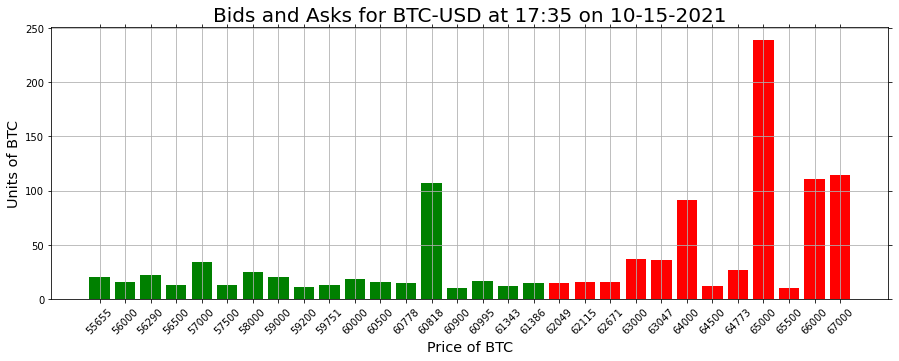

In [92]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
price = requests.get(base_url + products + pair + ticker).json()
price = float(price['price'])
bound = .1
price_upper = price * (1+bound)
price_lower = price * (1-bound)
ob_range_twit_chart(og_ob, upper=price_upper, lower=price_lower, metric='amount')